In [1]:
#!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 9.9 MB 41.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


# Importing Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [5]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [6]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [7]:
df=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/Coal Power.csv')

In [8]:
df.head()

,Unnamed: 0,Total consumption : Texas : electric power (total) : quarterly (short tons)
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


In [9]:
df.rename(columns={'Unnamed: 0':'Year-Quarter','Total consumption : Texas : electric power (total) : quarterly (short tons)':'Total_Consumption'}, inplace=True)
df.head()

,Year-Quarter,Total_Consumption
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


lets see the original dataset then we will split into train and test

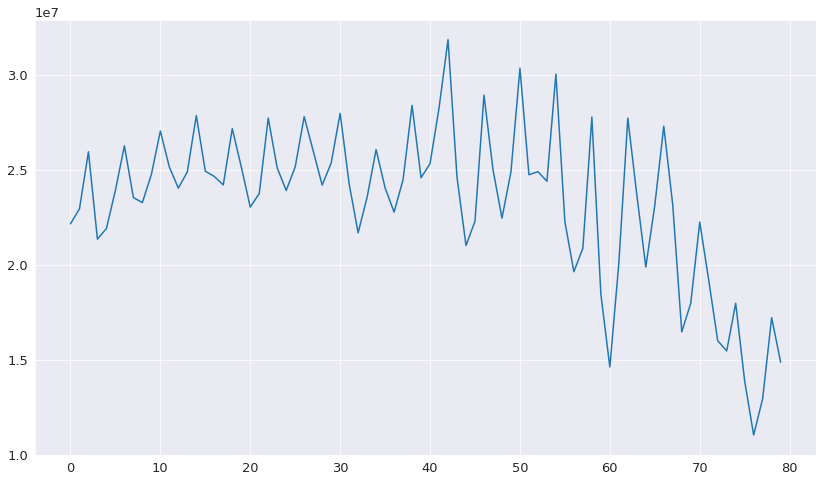

In [10]:
plt.plot(df['Total_Consumption'])

----------------------------------------------------------------------------
- We can see mix trend in the dataset but its increasing for sure
- Variance is also significant
- Seasonality is not so visible but lets decide it on the basis of ACF and PACF plots
----------------------------------------------------------------------------

Splitting the dataset into train and test

In [11]:
df.shape

(80, 2)

In [12]:
df=df['Total_Consumption']

In [17]:
n=int(df.shape[0]*0.85) #test size=15% data
train=df.iloc[:n]
test=df.iloc[n:]


In [18]:
train.shape

(68,)

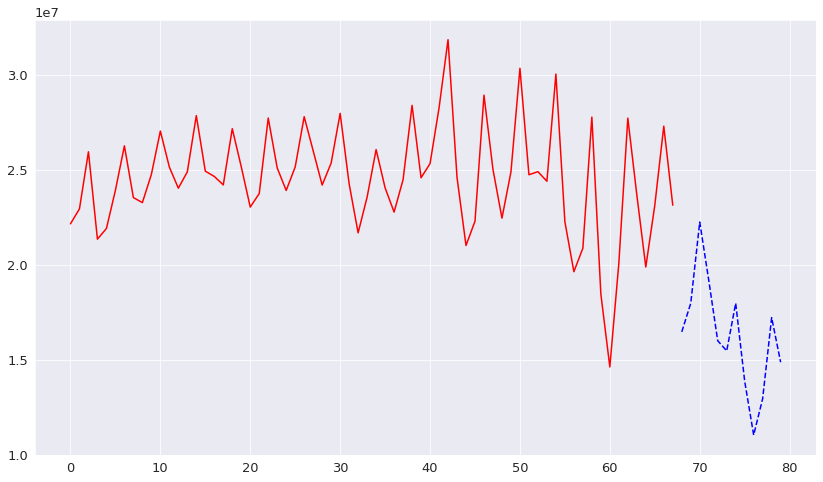

In [19]:
plt.plot(train,'r')
plt.plot(test,'b--')

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [22]:
dicky_fuller_test(df)

ADF Statistic: 1.976303
p-value: 0.998641
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590
Fail to reject the null hypothesis (H0), the data is non-stationary


In [23]:
dicky_fuller_test(train)

ADF Statistic: -0.073142
p-value: 0.952049
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
Fail to reject the null hypothesis (H0), the data is non-stationary


- We can conclude that the data is non stationary as p- value is significantly greater than 0.05. 
- It means our initial observation was corrent that the data has varing mean and variance with time 

In [24]:
# lets decompose our Time series into its components

In [25]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=12)

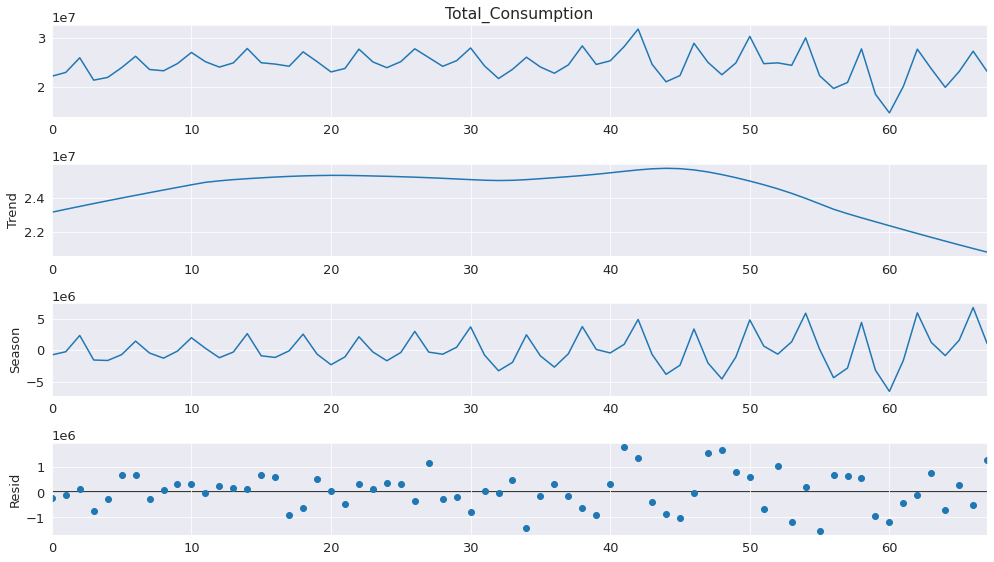

In [26]:
res = stl.fit()
fig = res.plot()

- There is gradual increase in trend
- there seems to be some Seasonality so our initial observation was correct
- residuals are also random

lets transform the data by differencing method to get rid of trend

In [27]:
df_diff1 = difference(train, interval=1)

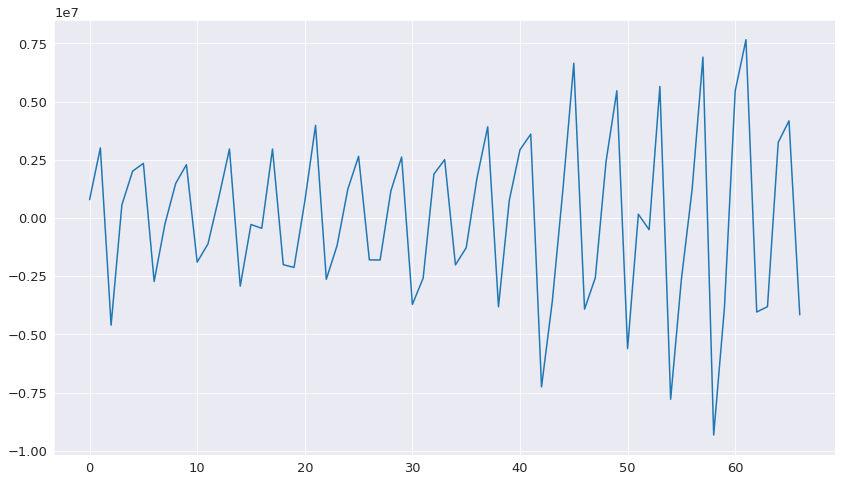

In [28]:
plt.plot(df_diff1)

In [29]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff1)

ADF Statistic: -2.532767
p-value: 0.107704
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
Fail to reject the null hypothesis (H0), the data is non-stationary


In [30]:
df_diff2 = difference(df_diff1, interval=1)

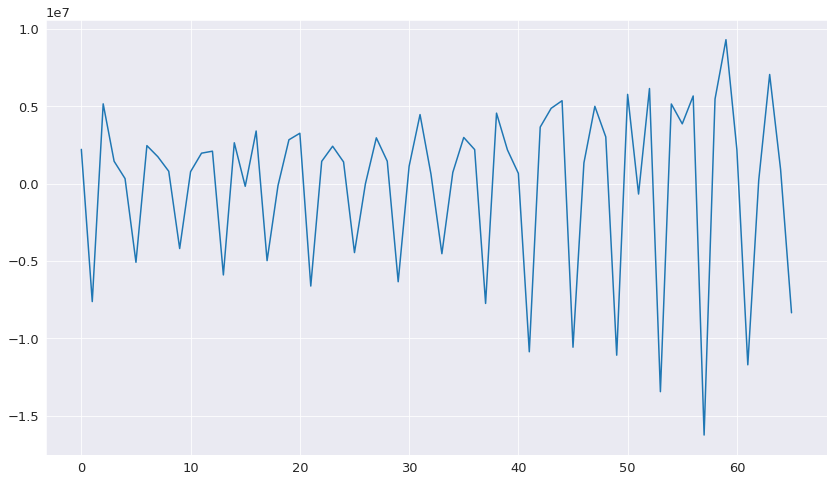

In [32]:
plt.plot(df_diff2)

In [31]:
dicky_fuller_test(df_diff2)

ADF Statistic: -6.086441
p-value: 0.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
Reject the null hypothesis (H0), the data is stationary.


In [38]:
df_deseason1 = difference(df_diff2, interval=4)

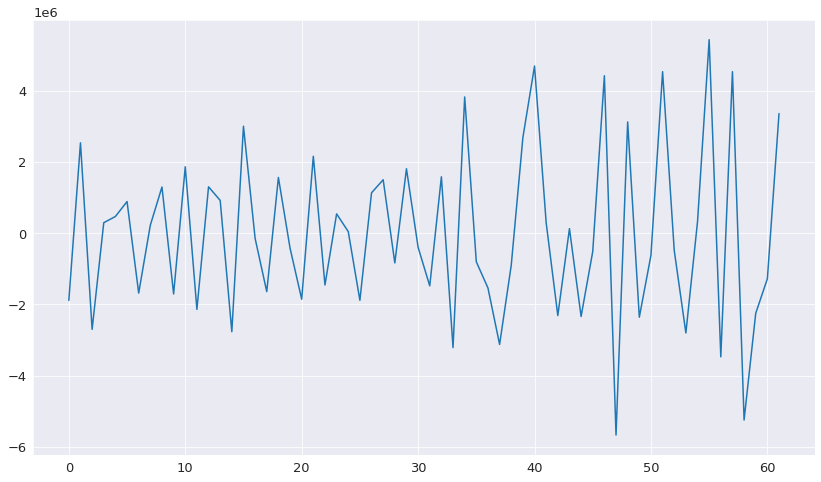

In [39]:
plt.plot(df_deseason1)

In [40]:
dicky_fuller_test(df_deseason1)

ADF Statistic: -5.003354
p-value: 0.000022
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597
Reject the null hypothesis (H0), the data is stationary.


-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


**ACF-PACF Plots**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


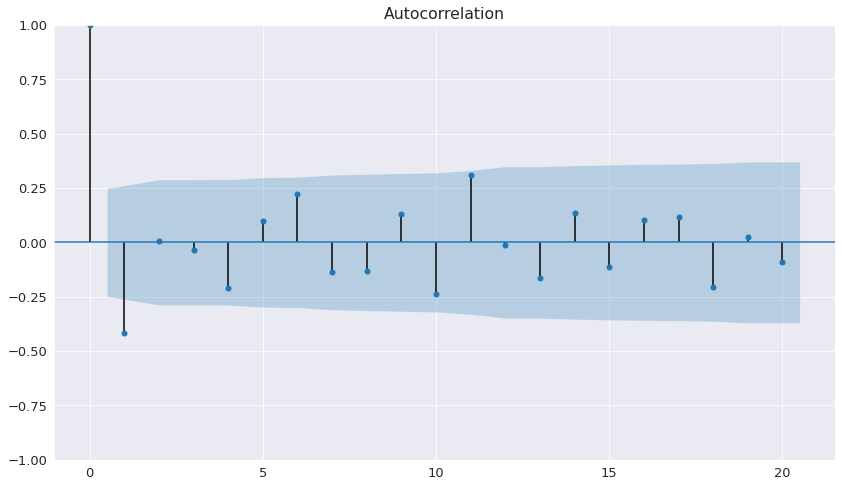

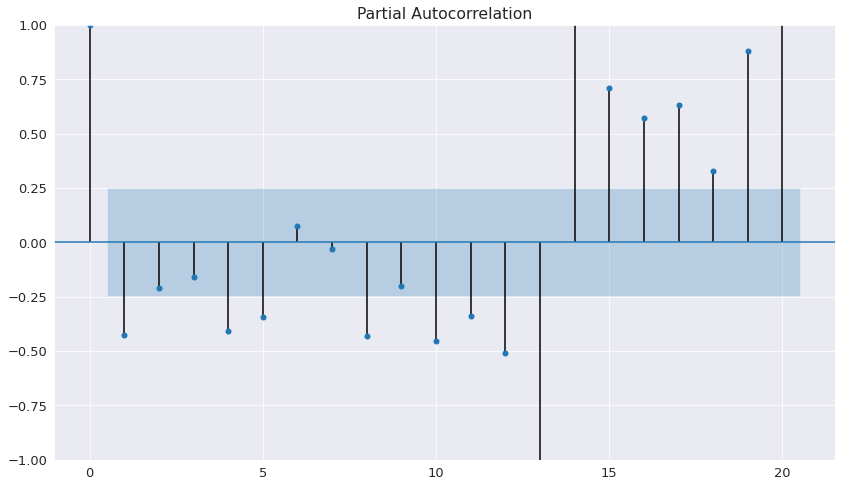

In [50]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_deseason1,lags=20)
fig2 = sm.graphics.tsa.plot_pacf(df_deseason1,lags=20)

**Observations**
- From PACF plot we can say that p=1 as after lag 1 most for the lags are not significant
- From ACF plot q=1 as second lag is very close to significance threshold region 
- d value would be 1 as we have differenced once to make the series stationary
- In SARIMA model P,D,Q,s =0 as no seasonality present in the series

In [49]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(0,2,0), seasonal_order=(0,0,0,0)) 
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:      Total_Consumption   No. Observations:                   68
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -1117.058
Date:                Sat, 26 Nov 2022   AIC                           2236.117
Time:                        09:49:58   BIC                           2238.306
Sample:                             0   HQIC                          2236.982
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.853e+13   4.29e+12      6.655      0.000    2.01e+13    3.69e+13
Ljung-Box (L1) (Q):                   6.01   Jarque-Bera (JB):                13.15
Prob(Q):                              0.01   Pr

we can see that ma.L1 term's  p value > 0.05 which means MA(q) process is not applicable here. But lets check Auto Arima and decide  

In [ ]:
pred_no=test.shape[0]
pred_no

29

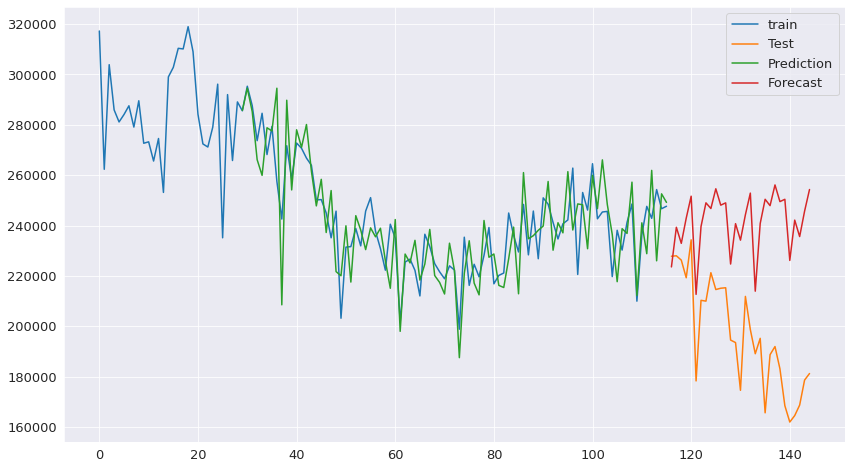

In [ ]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is just a straight line  because seasonality wasn’t taken into consideration.

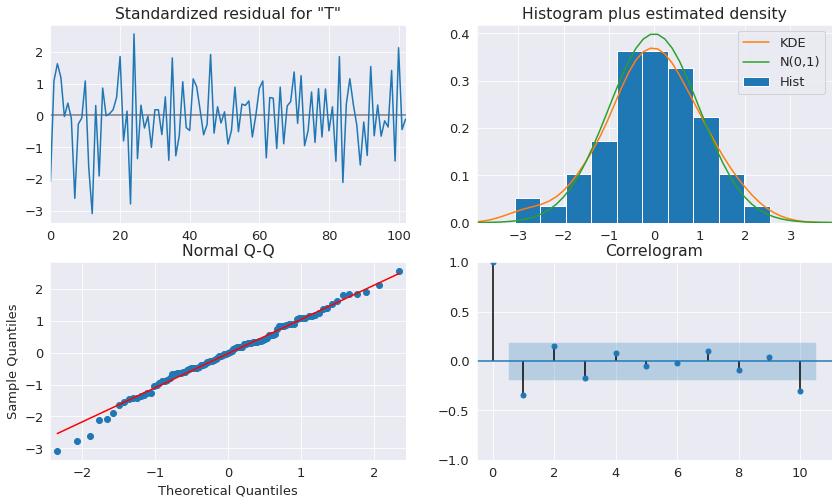

In [ ]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
test.shape

(29,)

In [ ]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

50149.30832952869

In [ ]:
tsforecast.describe()

count        29.000000
mean     241370.465062
std       11744.412237
min      212645.571367
25%      235610.183455
50%      244291.092655
75%      249498.711516
max      256120.646113
Name: predicted_mean, dtype: float64

# **Auto-Arima**

In [44]:
from pmdarima import auto_arima

In [45]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5,
                        error_action="ignore",trace = True,
                         suppress_warnings=True,stepwise = True,
                         random_state=20,n_fits= 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2215.747, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2217.017, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2215.817, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2213.755, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2214.756, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.161 seconds


In [46]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1105.878
Date:                Sat, 26 Nov 2022   AIC                           2213.755
Time:                        09:45:09   BIC                           2215.960
Sample:                             0   HQIC                          2214.627
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.252e+13   2.28e+12      5.503      0.000    8.06e+12     1.7e+13
Ljung-Box (L1) (Q):                   1.58   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.21   Pr

## Forecasting using Auto ARIMA

In [47]:
forecast =pd.DataFrame(arima_model.predict(n_periods=pred_no),columns=['forecast'],index=test.index)
forecast

NameError: ignored

In [ ]:
forecast_df =pd.DataFrame(arima_model.predict(n_periods=12),columns=['forecast'],index=test.index)
forecast_df=pd.concat([forecast, test],axis=1)
forecast_df

In [ ]:
forecast_df.describe()

In [ ]:
#plotting the graph

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Forecast')
#plt.plot(tsforecast,label='Forecast')
plt.legend()

In [ ]:
#plotting diagnostics

d= arima_model.plot_diagnostics()

In [ ]:
rms = np.sqrt(mean_squared_error(test,forecast_df['forecast'])) # same as squared=False
print('Rmse value:',rms) 

Rmse of Auto Arima model(54,945) is slightly higher than that of manual Arima(54,015)

- lets combine values of auto arima and manual arima to check if we get good model

In [ ]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(1,1,0), seasonal_order=(1,1,0,12)) # q=0 as only AR model is required as per AUTO-ARIMA and p value associated with ma
my_model_res = my_model.fit()
print(my_model_res.summary())

In [ ]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

In [ ]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

- we can see significant drop in the rsme value from 54,015 to 50,149.
- So this manual AR model which considers both trend and seasonality performs better

# **Holt-Winter**

In [ ]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [ ]:
model = Holt(train)
result = model.fit()
result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.5471428571428572,
 'smoothing_trend': 0.5471428571428572,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 317275.0,
 'initial_trend': -54936.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:             Th.barrels   No. Observations:                  116
Model:                           Holt   SSE                    44096860314.573
Optimized:                       True   AIC                           2299.703
Trend:                       Additive   BIC                           2310.718
Seasonal:                        None   AICC                          2300.474
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         18:28:51
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5471429                alpha                 True
smoothing_trend            0.5471429                

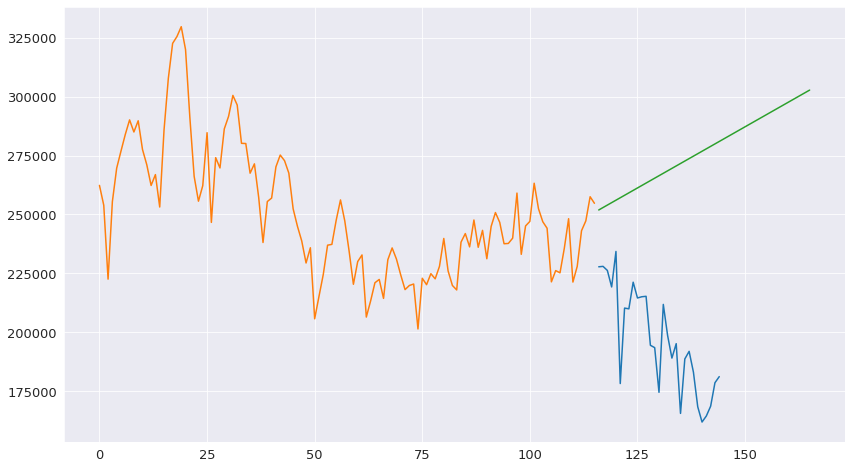

In [ ]:
plt.plot(test)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(50))

In [ ]:
rmse = mean_squared_error(test, result.forecast(pred_no), squared=False)
rmse

75402.28527471522

- As rmse value of holt model is 75,402 which is greater than rmse value of manual ARIMA(50,149) Model, therefore we can say that for this scenario ARIMA model fits better 

- lets check Holt-winter model as well 

In [ ]:
# Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12)

In [ ]:
result3 = model.fit()
result3.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.6060714285714286,
 'smoothing_trend': 0.027548701298701295,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 276878.0166666666,
 'initial_trend': 1278.2643939394075,
 'initial_seasons': array([0.9977305 , 0.86909341, 1.01982152, 0.99107742, 1.0437386 ,
        1.03424694, 1.05675965, 1.03614027, 1.00309952, 0.9927683 ,
        0.97564727, 0.97987661]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

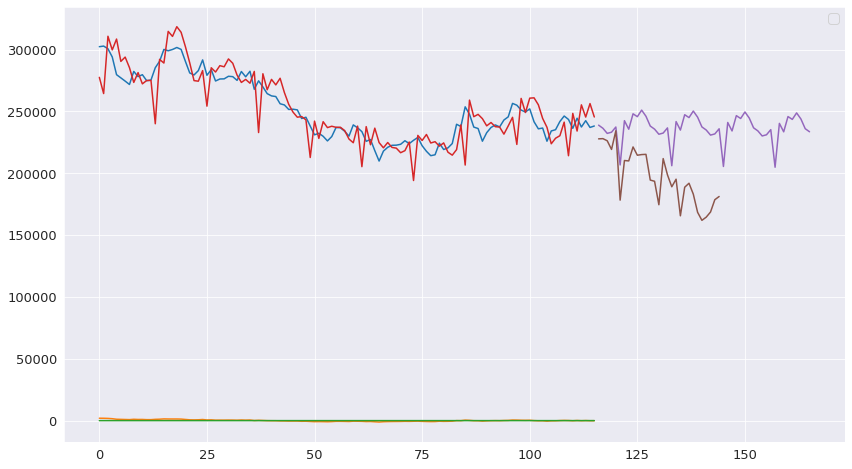

In [ ]:
plt.plot(result3.level)
plt.plot(result3.trend)
plt.plot(result3.season)
plt.plot(result3.fittedvalues) #learning part 
plt.plot(result3.forecast(50))
plt.plot(test)
plt.legend()

In [ ]:
print(result3.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Th.barrels   No. Observations:                  116
Model:             ExponentialSmoothing   SSE                    13263843729.005
Optimized:                         True   AIC                           2184.347
Trend:                         Additive   BIC                           2228.405
Seasonal:                Multiplicative   AICC                          2191.399
Seasonal Periods:                    12   Date:                 Sun, 20 Nov 2022
Box-Cox:                          False   Time:                         18:34:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6060714                alpha                 True
smoothing_trend          

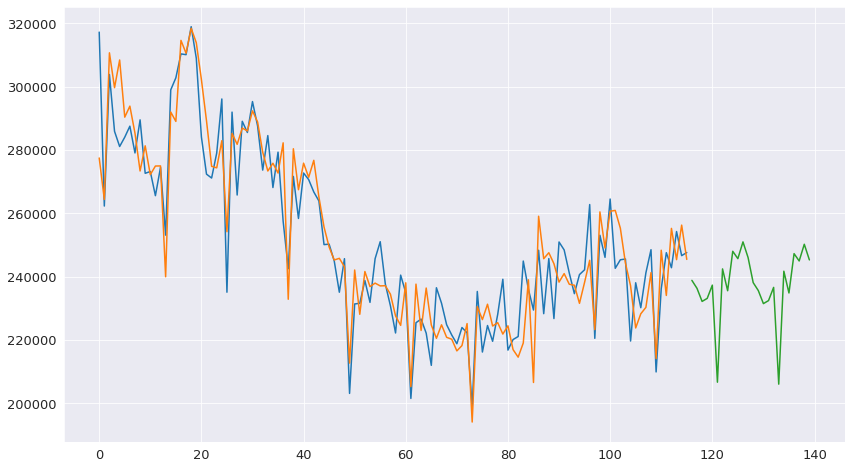

In [ ]:
plt.plot(train)
plt.plot(result3.fittedvalues)
plt.plot(result3.forecast(24))

In [ ]:
rmse = mean_squared_error(test, result3.forecast(pred_no), squared=False)
rmse

45472.017371540984

additive model

In [ ]:
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)

In [ ]:
result4 = model2.fit()
result4.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.5707142857142857,
 'smoothing_trend': 0.02717687074829932,
 'smoothing_seasonal': 0.022593984962406014,
 'damping_trend': nan,
 'initial_level': 276878.0166666666,
 'initial_trend': 1278.2643939394075,
 'initial_seasons': array([  -921.64149306, -35189.50607639,   5682.72309028,  -2205.54774306,
         11856.95225694,   9460.61892361,  15729.22309028,   9856.56684028,
           695.27517361,  -2389.18315972,  -6977.65190972,  -5597.82899306]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result4.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Th.barrels   No. Observations:                  116
Model:             ExponentialSmoothing   SSE                    14132753033.575
Optimized:                         True   AIC                           2191.708
Trend:                         Additive   BIC                           2235.765
Seasonal:                      Additive   AICC                          2198.759
Seasonal Periods:                    12   Date:                 Sun, 20 Nov 2022
Box-Cox:                          False   Time:                         18:37:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5707143                alpha                 True
smoothing_trend          

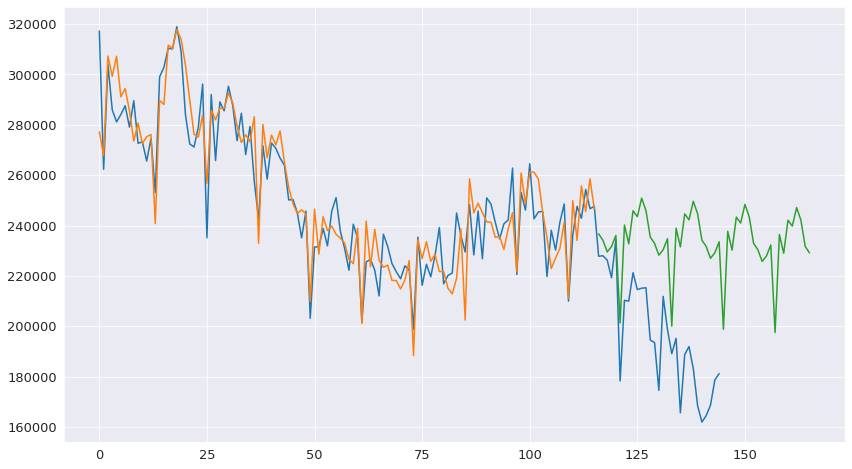

In [ ]:
plt.plot(df)
plt.plot(result4.fittedvalues)
plt.plot(result4.forecast(50))

In [ ]:
rmse = mean_squared_error(test, result4.forecast(pred_no), squared=False)
rmse

43295.23075388223

- so we can conclude that holt-Winter model with additive trend and additive seasonality gives us the best model among others, as it gives is rmse value of 43,295 as compared to manual SARIMA model which previously gave us rsme value of 50,149